## Test train.py

In [ ]:
!python ./train/test_train.py 

Loaded pretrained weights for efficientnet-b4
Iteration:  16%|██▋             | 162/985 [28:05<2:23:22, 10.45s/it, loss=0.667]

# DEEPFAKE DETECTION PROJECT

In [ ]:
!pip3 install -r requirements.txt

In [84]:
import sys

sys.path.append('/root/DeepFakeDetection/')

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from tqdm import tqdm

from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from functools import partial

from blazeface import BlazeFace

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from efficientnet_pytorch import EfficientNet
from poutyne.framework import Model, ModelCheckpoint, BestModelRestore, CSVLogger
import boto3
import io
import botocore
import tempfile
from pathlib import PurePosixPath
import pickle

In [7]:
s3_resource = boto3.resource('s3')
s3_client = boto3.client('s3')
bucket_name = 'deepfake-detection'
bucket = s3_resource.Bucket(bucket_name)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Datasets Preprocessing

In [8]:
FFPP_SRC = 'datasets/'
VIDEODF_SRC = os.path.join(FFPP_SRC, 'ffpp_videos.pkl')

BLAZEFACE_WEIGHTS = "blazeface/blazeface.pth"
BLAZEFACE_ANCHORS = "blazeface/anchors.npy"

FACES_DST = os.path.join(FFPP_SRC, 'extract_faces')
FACESDF_DST = os.path.join(FACES_DST, 'ffpp_faces.pkl')
CHECKPOINT_DST = os.path.join(FACES_DST, 'checkpoint')

### FF++ Preprocessing

In [9]:
def preprocess_ffpp(source_dir, video_dataset_path):
    """
    Preprocessing video dataset : Set the label of each video {0 for real video, 
    1 for fake video} and the video original of fake videos.
    :param source_dir: the parent directory that contains all videos (real or 
                        fake)
    :param video_dataset_path: Path to save the videos DataFrame[path, name, 
                                label, original]
    """ 
    try:
        s3_resource.Object(bucket_name, video_dataset_path).load()
        file_exists = True
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            file_exists = False
        else:
            raise

    # Charger le fichier de checkpoint depuis S3 s'il existe
    if file_exists:
        df_videos = pickle.loads(s3_resource.Bucket(bucket_name).Object(video_dataset_path).get()['Body'].read())
    else :
        # Si le fichier n'existe pas dans S3, vous pouvez créer le DataFrame de la façon suivante :
        print('Creating video DataFrame')
        # df_videos = pd.DataFrame(columns=['path', 'label', 'name', 'original'])

        # Initialisez une liste vide pour stocker les chemins des fichiers .mp4
        mp4_files = []

        # Appelez la méthode list_objects_v2 de l'objet client S3 en spécifiant le paramètre ContinuationToken
        # lors de chaque itération, jusqu'à ce qu'il n'y ait plus d'objets à récupérer 
        objects_list = s3_client.list_objects_v2(
            Bucket=bucket_name, Prefix=source_dir
        )
        while True:
            # Parcourez la liste des objets et ajoutez le chemin de chaque fichier mp4 à la liste
            for obj in objects_list['Contents']:
                # Vérifiez si l'objet est un fichier mp4
                if obj['Key'].endswith('.mp4'):
                    # Ajoutez le chemin du fichier à la liste
                    mp4_files.append(obj['Key'])
            
            # Vérifiez si il y a une suite de résultats
            if 'NextContinuationToken' in objects_list:
                # Si oui, récupérez la suite des résultats en spécifiant le ContinuationToken
                objects_list = s3_client.list_objects_v2(
                    Bucket=bucket_name, Prefix=source_dir, ContinuationToken=objects_list['NextContinuationToken']
                )
            else:
                # Si non, sortez de la boucle
                break
        
        # Créez le DataFrame en utilisant la liste des chemins de fichiers .mp4
        df_videos = pd.DataFrame({'path': mp4_files})
        # Enlevez le repertoire racine datasets/ dans le path
        df_videos['path'] = df_videos['path'].replace('datasets/', '', regex=True)
        # Convertissez les chaînes de caractères en objets PurePosixPath
        df_videos['path'] = df_videos['path'].apply(lambda x: PurePosixPath(x))           

        # 1 if fake, otherwise 0
        df_videos['label'] = df_videos['path'].map(
            lambda x: 1 if x.parts[0] == 'manipulated_sequences' else 0)
        
        source = df_videos['path'].map(lambda x: x.parts[1]).astype('category')
        df_videos['name'] = df_videos['path'].map(lambda x: x.with_suffix('').parts[-1])
        df_videos['path'] = df_videos['path'].map(lambda x: str(x))

        df_videos['original'] = -1 * np.ones(len(df_videos), dtype=np.int16)
        # Mettre dans la colonne original l'index de l'original des fakes
        df_videos.loc[(df_videos['label'] == 1) & (source != 'DeepFakeDetection'), 'original'] = \
            df_videos[(df_videos['label'] == 1) & (source != 'DeepFakeDetection')]['name'].map(
                lambda x: df_videos.index[np.flatnonzero(df_videos['name'] == x.split('_')[0])[0]]
            )
        df_videos.loc[(df_videos['label'] == 1) & (source == 'DeepFakeDetection'), 'original'] = \
            df_videos[(df_videos['label'] == 1) & (source == 'DeepFakeDetection')]['name'].map(
                lambda x: df_videos.index[
                    np.flatnonzero(df_videos['name'] == x.split('_')[0] + '__' + x.split('__')[1])[0]]
            )
    
        # Enregistrez le DataFrame dans S3
        print('Saving video DataFrame to {}'.format(video_dataset_path))
        buf = io.BytesIO()
        df_videos.to_pickle(buf)
        buf.seek(0)
        bucket.upload_fileobj(buf, video_dataset_path)
    
    print('Real videos: {:d}'.format(sum(df_videos['label'] == 0)))
    print('Fake videos: {:d}'.format(sum(df_videos['label'] == 1)))

In [10]:
# preprocess ff++ data
preprocess_ffpp(FFPP_SRC, VIDEODF_SRC)

Real videos: 1000
Fake videos: 2000


### Extract faces

In [11]:
def extract_faces_on_video(video_df, source_dir, faces_dir, checkpoint_dir, 
                           blazeface, num_frames, face_size=224, margin=0.25):
    """
    This function extracts `num_frames` frames in the videos that contain a face.
    :param video_df: the DataFrame that contains all informations about the 
                    datasets. It has the following columns: [path, name, 
                    label, original].
    :param source_dir: the parent directory that contains the datasets
    :param faces_dir: the directory path to save the extracted faces from the 
                    datasets
    :param checkpoint_dir: the directory path to save the DataFrame[path, label,
                    video, original, frame_index, score, detection] of the 
                    extracted faces
    :param blazeface: a Balazeface object that will be used as face detector in
                    all frames
    :param num_frames: number of frames to extract in each video.
    :param face_size (default = 224) : each frame extracted will have the size
                    face_size x face_size
    :param margin (default = 0.25) : Offset margin of face detection.
    """
    video_idx, video_df = video_df
    faces_checkpoint_path = Path(checkpoint_dir).joinpath(video_df['path'].split('.')[0] + '_faces.pkl')
    
    try:
        s3_resource.Object(bucket_name, str(faces_checkpoint_path)).load()
        file_exists = True
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            file_exists = False
        else:
            raise
        
    if file_exists: 
        faces = pickle.loads(s3_resource.Bucket(bucket_name).Object(str(faces_checkpoint_path)).get()['Body'].read())
        return faces
        
    else :
        # Télécharger la vidéo depuis S3 dans un buffer
        video_path = Path(source_dir).joinpath(video_df['path'])
        url = s3_client.generate_presigned_url(ClientMethod='get_object', Params={ 'Bucket': bucket_name, 'Key': str(video_path) })
        reader =  cv2.VideoCapture(url)
        # Obtenir le nombre de frames de la vidéo
        frame_count = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))
        # Obtenir un tableau d'indices de frames uniformément répartis dans la vidéo
        frame_idx = np.unique(np.linspace(0, frame_count - 1, num_frames, dtype=int))
        # Get the frames choosen
        frames, idx = [], 0
        # Tant que la vidéo peut être lue
        while reader.grab():
            if idx in frame_idx:
                ret, frame = reader.retrieve()
                if not ret or frame is None:
                    print("Error retrieving frame %d from movie %s" % (frame_idx, path))
                    break
                frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            idx += 1
        frames = np.stack(frames) # Empiler les frames dans un tableau NumPy
        
        # Obtenir la largeur et la hauteur cibles pour le modèle BlazeFace
        target_w, target_h = blazeface.input_size
        # Pour chaque frame, obtenir plusieurs tuiles de taille target_w x target_h
        num_frames, height, width, _ = frames.shape
            # Définir la taille de chaque tuile en prenant la plus petite valeur parmi height, width et 720
        split_size = min(height, width, 720)
        x_step = (width - split_size) // 2
        y_step = (height - split_size) // 2
        num_h = (height - split_size) // y_step + 1 if y_step > 0 else 1
        num_w = (width - split_size) // x_step + 1 if x_step > 0 else 1

        tiles = np.zeros((num_frames * num_h * num_w, target_h, target_w, 3), 
                        dtype=np.uint8)
        i = 0
        for f in range(num_frames):
            y = 0
            for _ in range(num_h):
                x = 0
                for __ in range(num_w):
                    # Découper une tuile à partir de la frame actuelle
                    crop = frames[f, y:y + split_size, x:x + split_size, :]
                    # Redimensionner la tuile à la taille cible en utilisant une interpolation par aire
                    tiles[i] = cv2.resize(crop, (target_w, target_h), 
                                        interpolation=cv2.INTER_AREA)
                    x += x_step
                    i += 1
                y += y_step

        # Run the face detector. The result is a list of PyTorch tensors
        detections = blazeface.predict_on_batch(tiles, apply_nms=False)
        # Convert the detections from 128x128 back to the original frame size
        for i in range(len(detections)):
            # ymin, xmin, ymax, xmax
            for k in range(2):
                detections[i][:, k * 2] = (detections[i][:, k * 2] * target_h) * split_size / target_h
                detections[i][:, k * 2 + 1] = (detections[i][:, k * 2 + 1] * target_w) * split_size / target_w

        # Because we have several tiles for each frame, combine the predictions from these tiles.
        combined_detections = []
        i = 0
        for f in range(num_frames):
            detections_for_frame = []
            y = 0
            for _ in range(num_h):
                x = 0
                for __ in range(num_w):
                    # Adjust the coordinates based on the split positions.
                    if detections[i].shape[0] > 0:
                        for k in range(2):
                            detections[i][:, k * 2] += y
                            detections[i][:, k * 2 + 1] += x
                    
                    detections_for_frame.append(detections[i])
                    x += x_step
                    i += 1
                y += y_step
                
            combined_detections.append(torch.cat(detections_for_frame))
        if len(combined_detections) == 0:
            return None
        detections = blazeface.nms(combined_detections)
        # Crop the faces out of the original frame.
        faces = []
        for i in range(len(detections)):
            offset = torch.round(margin * (detections[i][:, 2] - detections[i][:, 0])) # margin 0.2
            detections[i][:, 0] = torch.clamp(detections[i][:, 0] - offset * 2, min=0)  # ymin
            detections[i][:, 1] = torch.clamp(detections[i][:, 1] - offset, min=0)  # xmin
            detections[i][:, 2] = torch.clamp(detections[i][:, 2] + offset, max=height)  # ymax
            detections[i][:, 3] = torch.clamp(detections[i][:, 3] + offset, max=width)  # xmax
            
            # Get the first best scored face
            score, face, detection = 0, None, None
            for j in range(len(detections[i])):
                if score < detections[i][j][16].cpu():
                    detection = detections[i][j].cpu()
                    ymin, xmin, ymax, xmax = detection[:4].cpu().numpy().astype(int)
                    face = frames[i][ymin:ymax, xmin:xmax, :]
                    score = detection[16]
                    break
            if face is not None:
                image = Image.fromarray(face)
                # Crop the image to face_size x face_size
                top, left, bottom, right = detection[:4].cpu().numpy().astype(int)
                x_ctr = (left + right) // 2
                y_ctr = (top + bottom) // 2
                new_top = max(y_ctr - face_size // 2, 0)
                new_bottom = min(new_top + face_size, height)
                new_left = max(x_ctr - face_size // 2, 0)
                new_right = min(new_left + face_size, width)
                image.crop([new_left, new_top, new_right, new_bottom])
                # Save image
                face_path = Path(faces_dir).joinpath(video_df['path']).joinpath('frame_{}.jpg'.format(frame_idx[i]))
                buf = io.BytesIO()
                image.save(buf, format="jpeg")
                object = bucket.Object(str(face_path))
                object.put(Body=buf.getvalue())
                faces.append({
                    'path': str(Path(video_df['path']).joinpath('frame_{}.jpg'.format(frame_idx[i]))),
                    'label': video_df['label'],
                    'video': video_idx,
                    'original': video_df['original'],
                    'frame_index': frame_idx[i],
                    'score': float(score.numpy()),
                    'detection': detection[:4].cpu().numpy().astype(int)
                })
            # Save checkpoint
            buf = io.BytesIO()
            pd.DataFrame(faces).to_pickle(buf)
            buf.seek(0)
            bucket.upload_fileobj(buf, str(faces_checkpoint_path))

        return faces


In [12]:
def extract_faces(source_dir, videos_df, faces_dir, faces_df, checkpoint_dir, 
                  frames_per_video=15, batch_size=32, face_size=224, thread_num=7):
    """
    This function extracts all frames in the dataset that contain a face.
    :param source_dir: the parent directory that contains the datasets
    :param videos_df: the path of the DataFrame containing all informations 
                    about the videos in the dataset.
    :param faces_dir: the directory path to save the extracted faces from the 
                    datasets
    :param faces_df: the path to save the DataFrame containing all informations 
                    about the extracted faces.
    :param checkpoint_dir: the directory path to save the DataFrame[path, label,
                    video, original, frame_index, score, detection] of the 
                    extracted faces
    :param frames_per_video (default = 15): number of frames to extract in each
                    video.
    :param batch_size (default = 16): batch size of videos to treat together.
    :param face_size (default = 224) : each frame extracted will have the size
                    face_size x face_size
    :thread_num (default = 4): number of threads to be used during the 
                    extraction.
    """
    # On vérifie si ffpp_faces.pkl existe
    try:
        s3_resource.Object(bucket_name, faces_df).load()
        file_exists = True
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            file_exists = False
        else:
            raise

    # Charger le fichier de checkpoint depuis S3 s'il existe
    if file_exists:
        df_faces = pickle.loads(s3_resource.Bucket(bucket_name).Object(faces_df).get()['Body'].read())
        print('We got {} faces'.format(len(df_faces)))
        print('Faces DataFrame Loaded')
        return df_faces
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    print('Loading video DataFrame')
    df_videos = pickle.loads(s3_resource.Bucket(bucket_name).Object(videos_df).get()['Body'].read())
    
    print('Loading Blazeface model')
    blazeface_net = BlazeFace().to(device)
    blazeface_net.load_weights(io.BytesIO(s3_client.get_object(Bucket=bucket_name, Key=BLAZEFACE_WEIGHTS)['Body'].read()))
    blazeface_net.load_anchors(io.BytesIO(s3_client.get_object(Bucket=bucket_name, Key=BLAZEFACE_ANCHORS)['Body'].read()))    
    blazeface_net.min_score_thresh = 0.8
    
    ## Face extraction
    with ThreadPoolExecutor(thread_num) as pool:
        for batch_idx0 in tqdm(np.arange(start=0, stop=len(df_videos), step=batch_size),
                               desc='Extracting faces'):
            list(pool.map(partial(extract_faces_on_video,
                          source_dir=source_dir,
                          faces_dir=faces_dir,
                          checkpoint_dir=checkpoint_dir,
                          blazeface=blazeface_net,
                          num_frames=frames_per_video,
                          face_size=face_size,
                          ),
                          df_videos.iloc[batch_idx0:batch_idx0 + batch_size].iterrows()))
    
    faces_dataset = []
    for _, df in tqdm(df_videos.iterrows(), total=len(df_videos), desc='Collecting faces results'):
        face_checkpoint = Path(checkpoint_dir).joinpath(df['path'].split('.')[0] + '_faces.pkl')
        try:
            s3_resource.Object(bucket_name, str(face_checkpoint)).load()
            face_checkpoint_exists = True
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                file_exists = False
            else:
                raise
        if face_checkpoint_exists:
            df_face = pickle.loads(s3_resource.Bucket(bucket_name).Object(str(face_checkpoint)).get()['Body'].read())
            faces_dataset.append(df_face)
        else:
            print(f'Checkpoint file {face_checkpoint} does not exist')
            
    df_faces = pd.concat(faces_dataset, axis=0)
    buf = io.BytesIO()
    df_faces.to_pickle(buf)
    buf.seek(0)
    bucket.upload_fileobj(buf, faces_df)
    print('We got {} faces'.format(len(df_faces)))
    print('Completed!')
    return df_faces

In [13]:
# Run extraction
df_faces = extract_faces(FFPP_SRC, VIDEODF_SRC, FACES_DST, FACESDF_DST,  CHECKPOINT_DST)

We got 44994 faces
Faces DataFrame Loaded


## Dataset processing

In [14]:
IMG_SIZE = 224
BATCH_SIZE = 128

### Split dataset on original video

In [15]:
PREPROCESSED_DST = 'preprocessed_data'

def copy_preprocessed_data(prefix, keys):
    for key in tqdm(keys) :
        copy_source = {
            'Bucket': bucket_name,
            'Key': f'{FACES_DST}/{key}'
        }
        s3_resource.meta.client.copy(copy_source, bucket_name, f'{PREPROCESSED_DST}/{prefix}/{key}')

In [16]:
def make_splits(df_faces, train_ratio=0.7, val_ratio=0.15):
    """
    Splitting the dataset into three subsets : train, validation and test.
    """
    random_original_videos = np.random.permutation(df_faces[(df_faces['label'] == 0)]['video'].unique())
    train_num = int(len(random_original_videos) * train_ratio)
    val_num = int(len(random_original_videos) * val_ratio)
    train_original = random_original_videos[:train_num]
    val_original = random_original_videos[train_num: train_num + val_num]
    test_original = random_original_videos[train_num + val_num:]
    
    df_train = pd.concat([df_faces[df_faces['original'].isin(train_original)], 
                          df_faces[df_faces['video'].isin(train_original)]], ignore_index=True)
    df_val = pd.concat([df_faces[df_faces['original'].isin(val_original)], 
                        df_faces[df_faces['video'].isin(val_original)]], ignore_index=True)
    df_test = pd.concat([df_faces[df_faces['original'].isin(test_original)], 
                         df_faces[df_faces['video'].isin(test_original)]], ignore_index=True)
    
    return df_train, df_val, df_test

In [17]:
df_faces = pickle.loads(s3_resource.Bucket(bucket_name).Object(FACESDF_DST).get()['Body'].read())

In [18]:
df_faces.head()

,path,label,video,original,frame_index,score,detection
0,manipulated_sequences/Deepfakes/c23/videos/000...,1,0,2000,0,0.967828,"[53, 222, 270, 408]"
1,manipulated_sequences/Deepfakes/c23/videos/000...,1,0,2000,28,0.977729,"[51, 223, 273, 414]"
2,manipulated_sequences/Deepfakes/c23/videos/000...,1,0,2000,56,0.961462,"[51, 232, 276, 425]"
3,manipulated_sequences/Deepfakes/c23/videos/000...,1,0,2000,84,0.949439,"[49, 234, 268, 422]"
4,manipulated_sequences/Deepfakes/c23/videos/000...,1,0,2000,112,0.975719,"[50, 233, 267, 419]"


In [19]:
paths = df_faces['path']
dir_paths = [os.path.dirname(p) for p in paths]
df_faces['dir_path'] = dir_paths
df_faces['s3_path'] = df_faces['dir_path'].map(lambda x: f's3://{bucket_name}/{FACES_DST}/{x}')

In [20]:
df_train, df_val, df_test = make_splits(df_faces)

In [21]:
r_train, _ = df_train.shape
r_val, _ = df_val.shape
r_test, _ = df_test.shape

print('Total dataset : {}'.format(r_train+r_val+r_test))
print('Total train : {}'.format(r_train))
print('Total val : {}'.format(r_val))
print('Total test : {}'.format(r_test))

Total dataset : 44994
Total train : 31499
Total val : 6745
Total test : 6750


In [22]:
# copy train, valid and test to specific folder 
# copy_preprocessed_data('train', df_train['path'])

### Transforms

In [23]:
pre_trained_mean, pre_trained_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.16), ratio=(0.3, 1.6)),
    transforms.Normalize(mean=pre_trained_mean, std=pre_trained_std)
])

val_tranform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=pre_trained_mean, std=pre_trained_std)
])

### Dataset

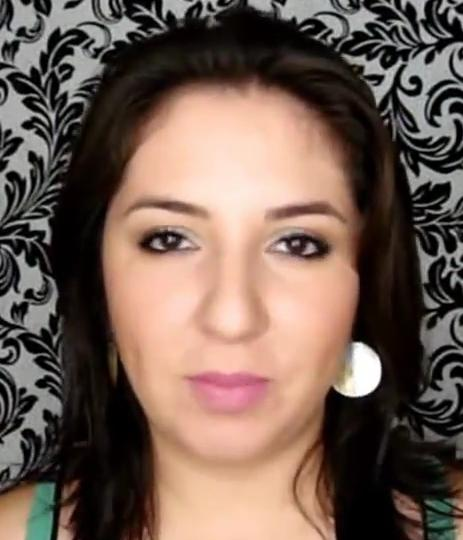

In [24]:
faces_dir = Path(FACES_DST)
img_path = df_faces.iloc[1]['path']

object = bucket.Object(str(faces_dir.joinpath('original_sequences/youtube/c23/videos/341.mp4/frame_177.jpg')))
response = object.get()
file_stream = response['Body']
Image.open(file_stream)

In [25]:
class FFPPDataset(Dataset):
    def __init__(self, df_faces, faces_dir=FACES_DST, transform=None):
        super().__init__()
        self.faces_dir = Path(faces_dir)
        self.data, self.targets = df_faces['path'], df_faces['label']
        self.transform = transform
        
    def __getitem__(self, index):
        img_path, target = self.data[index], self.targets[index]
        target = np.array([target,]).astype(np.float32)
        
        file_stream = bucket.Object(str(self.faces_dir.joinpath(img_path))).get()['Body']
        img = Image.open(file_stream)
        
        if self.transform is not None:
            img = self.transform(img)
        return img, target
    
    def __len__(self):
        return len(self.data)

In [26]:
from torch.utils.data import IterableDataset
from torchdata.datapipes.iter import IterableWrapper, S3FileLoader

class S3FFPPDataset(IterableDataset):
    def __init__(self, df, faces_dir=FACES_DST, shuffle_urls=False, transform=None):
        super().__init__()
        self.data = df
        self.paths = IterableWrapper(df['s3_path'].unique().tolist()).list_files_by_s3()
        self.targets = IterableWrapper(df['label'])
        if shuffle_urls:
            self.sharded_s3_urls = self.paths.shuffle().sharding_filter()
            self.s3_files = S3FileLoader(self.sharded_s3_urls)
        else:
            self.s3_files = S3FileLoader(self.paths)
        self.transform = transform
    
    def data_generator(self):
        try:
            while True:
                url, stream = next(self.s3_files_iterator)
                target = next(self.targets_iterator)
                
                target = np.array([target,]).astype(np.float32)
                img = Image.open(stream)
                
                if self.transform is not None:
                    img = self.transform(img)
                yield img, target

        except StopIteration:
            return

    def __iter__(self):
        self.s3_files_iterator = iter(self.s3_files)
        self.targets_iterator = iter(self.targets)
        return self.data_generator()

    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset = S3FFPPDataset(df_train, shuffle_urls=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, 
                          num_workers=0)

valid_dataset = S3FFPPDataset(df_val, transform=val_tranform)
val_loader = DataLoader(valid_dataset, batch_size=32, num_workers=0)

test_dataset = S3FFPPDataset(df_test, transform=val_tranform)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

In [ ]:
batch_train = next(iter(train_loader))
batch_train

## Entraîner le réseau EfficientNet

Modèle pré-entraîner nommé : efficientnet-b4




In [45]:
# Training configuration
# number of epochs to train for
num_epochs = 10

# learning rate
learning_rate = 1e-4

# loss_function
criterion = nn.BCEWithLogitsLoss()

In [46]:
def train(net, model_name):
    base_path = 'model_checkpoint'
    model_path = os.path.join(base_path, 
                            f'models/{model_name}' + '/best_epoch_{epoch}.ckpt')
    Path(model_path).parent.mkdir(parents=True, exist_ok=True)
    logs_file = os.path.join(base_path, f'logs/{model_name}/log.tsv')
    Path(logs_file).parent.mkdir(parents=True, exist_ok=True)

    callbacks = [
        # Save the weights in a new file when the current model is better than all 
        # previous models.
        ModelCheckpoint(model_path, monitor='val_bin_acc', mode='max', 
                        save_best_only=True, restore_best=True, verbose=True, 
                        temporary_filename=model_name + '_best_epoch.ckpt.tmp'),

        # Save the losses and accuracies for each epoch in a TSV.
        CSVLogger(logs_file, separator='\t'),
    ]

    params = (p for p in net.parameters() if p.requires_grad)
    optimizer = optim.Adam(params, lr=learning_rate, weight_decay=0.000001)

    model = Model(net, optimizer, criterion, batch_metrics=['bin_acc'])
    model.to(device)

    if Path(logs_file).exists():
        logs = pd.read_csv(logs_file, sep='\t')
        epochs = list(logs['epoch'])
        if len(epochs) != 0:
            best_epoch_idx = logs['val_bin_acc'].idxmax()
            best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
            model.load_weights(model_path.format(epoch=best_epoch))
            if num_epochs not in epochs:
                # Train
                model.fit_generator(train_loader, val_loader, epochs=num_epochs, initial_epoch=epochs[-1], callbacks=callbacks)
        else:
            model.fit_generator(train_loader, val_loader, epochs=num_epochs, callbacks=callbacks)
    else:
        model.fit_generator(train_loader, val_loader, epochs=num_epochs, callbacks=callbacks)
    
    logs = pd.read_csv(logs_file, sep='\t')
    
    best_epoch_idx = logs['val_bin_acc'].idxmax()
    best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
    print("Best epoch: %d" % best_epoch)
    
    metrics = ['loss', 'val_loss']
    plt.plot(logs['epoch'], logs[metrics])
    plt.legend(metrics)
    plt.title('Loss')
    plt.show()

    metrics = ['bin_acc', 'val_bin_acc']
    plt.plot(logs['epoch'], logs[metrics])
    plt.legend(metrics)
    plt.title('Accuracy')
    plt.show()

    return model

In [47]:
def test(model, test_loader):
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

### Freezant tous les paramètres de convolution

In [ ]:
efficientnet_a = EfficientNet.from_pretrained('efficientnet-b4')
efficientnet_a._fc = nn.Linear(efficientnet_a._conv_head.out_channels, 1)

for name, param in efficientnet_a.named_parameters():
    if not name.startswith('_fc'):
        param.requires_grad = False

model_a = train(efficientnet_a, 'efficientnet_a')
test(model_a, test_loader)

### En réentraînant quelques blocs

Réentraîner les 8 derniers blocs avec les deux dernières couches (couche de convolution et classificateur)

In [ ]:
efficientnet_b = EfficientNet.from_pretrained('efficientnet-b4')
efficientnet_b._fc = nn.Linear(efficientnet_b._conv_head.out_channels, 1)

names = [name for name, _ in list(efficientnet_b.named_parameters())[-109:]]
for name, param in efficientnet_b.named_parameters():
    if name not in names:
        param.requires_grad = False

model_b = train(efficientnet_b, 'efficientnet_b')
test(model_b, test_loader)

Réentraîner les 16 derniers blocs avec les deux dernières couches (couche de convolution et classificateur)

In [ ]:
efficientnet_c = EfficientNet.from_pretrained('efficientnet-b4')
efficientnet_c._fc = nn.Linear(efficientnet_c._conv_head.out_channels, 1)

names = [name for name, _ in list(efficientnet_c.named_parameters())[-213:]]
for name, param in efficientnet_c.named_parameters():
    if name not in names:
        param.requires_grad = False

model_c = train(efficientnet_c, 'efficientnet_c')
test(model_c, test_loader)

## Mécanisme d'attention

Ajouter un mécanisme d'attention visuelle : Spatial Transformer Network (Applique une transformation spatiale sur les
feature maps, lors du forward pass) 

In [ ]:
class EfficientNetAtt(EfficientNet):
    def __init__(self, blocks_args=None, global_params=None):
        super().__init__(blocks_args, global_params)
        
    def init_spatial_transformer(self):
        self.block_idx = 20
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(160, 160, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(160, 80, kernel_size=3),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(80 * 1 * 1, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], 
                                                    dtype=torch.float))
    
    def stn(self, inputs):
        inputs = inputs.clone()
        xs = self.localization(inputs)
        xs = xs.view(-1, 80 * 1 * 1)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, inputs.size(), align_corners=False)
        x = F.grid_sample(inputs, grid, align_corners=False)

        return x
    
    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)
            if idx == self.block_idx:
                x *= self.stn(x)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

In [ ]:
efficientnet_d = EfficientNetAtt.from_pretrained('efficientnet-b4')
efficientnet_d._fc = nn.Linear(efficientnet_d._conv_head.out_channels, 1)
efficientnet_d.init_spatial_transformer()

names = [name for name, _ in list(efficientnet_d.named_parameters())[-221:]]
for name, param in efficientnet_d.named_parameters():
    if name not in names:
        param.requires_grad = False

model_d = train(efficientnet_d, 'efficientnet_d')
test(model_d, test_loader)